---
# Documentation: [Managing content | Academic](https://sourcethemes.com/academic/docs/managing-content/)

title: "Modelling, Simulation and Control of Hydro-Power System - Part 5"
subtitle: "Improving the DAE approach using OOP with Python"
summary: "In this series I will show the entire process of developing a model, performing simulations and the use of different control techniques for decision support in flood management systems."
authors: []
tags: ["Flood Forecasting", "Model Predictive Control"]
categories: ["Flood Management"]
date: 2022-01-24T10:01:00
lastmod: 2022-01-28T10:01:00
featured: false
draft: false

# Featured image

# To use, add an image named `featured.jpg/png` to your page's folder.

# Focal points: Smart, Center, TopLeft, Top, TopRight, Left, Right, BottomLeft, Bottom, BottomRight.

image:
 caption: "Image by <a href='https://pixabay.com/users/russmac-756431/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=929406'>Russ McElroy</a> from <a href='https://pixabay.com/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=929406'>Pixabay</a>"
 focal_point: "Smart"
 preview_only: false

# Projects (optional).

# Associate this post with one or more of your projects.

# Simply enter your project's folder or file name without extension.

# E.g. `projects = ["internal-project"]` references `content/project/deep-learning/index.md`.

# Otherwise, set `projects = []`.

projects: ["Modelling, Simulation and Control of Hydro-power system"]
---

# Improving modularity of the lakes using Object Oriented Programming (OOP)

In the previous post I went through the steps of a "basic" implementation of the dynamics of the lakes using DAE approach. Using that working code, we can improve its modularity and reusability to implement series of lakes without repeting the basic code. With that we avoid incorporating small mistakes and also keep a clean, concise code that can be better reused and extended.

When it comes to a final design the components, there is no single, exact and perfect solution. There are multiple solutions that work, some may be better than others but all depends on the application and the required versatility and extensibility of the program.

To get a better idea of what I need, I will take into consideration a complete case provided by Petrone (2010), who developed a MPC for a hydro power valley consisting of 5 lakes and 4 section (reaches) of a river, with a tributary on the last section. The figure below illustrates this system:

![HydroPowerValley.png](https://drive.google.com/uc?export=view&id=15xzojtJ9pU0mmzcG0UiYCqVbL28RX4tf)

Figure 1- Hydro Power Valley System (Petrone, 2010). Figure from Euan Russano - Own work

This shows some basic principles to be followed:
- Physical "objects" (lakes, valves, turbines, etc) should be represented by objects in the code.
- The design follows a kind of Composite Pattern (if you don't know what I'm talking about it, please see [here](https://en.wikipedia.org/wiki/Composite_pattern))
- Each "object" should have some kind of "port" so it is possible to connect one to another. For example, the outflow of Lake 1 is connected to the inflow of the valve, so that $q_{out}^{lake1} = q_{in}^{valve}$
- The composition of the model should be very extensive, such that I can have an object "lake 1", which together with a valve is contained in a component "P1", which in turn is contained in the one entity of the model.

Once I setup the model, I may use it to do some simulations or leave some degree of freedom in certain variables to proform optimizations. In this sense, I also make a separation between the model itself and the kind of problem.
In OOP:
+ The entire model is one object, which I can have several copies of it during the execution of a program.
+ The specific problem being solved (simulation or optimization) is a higher-level object, which may "contain" an instance of the model and it is run according a specific configuration.

Using the Composite Pattern, the structure of the model shown in Figure 1 could be represented as follows.

![CompositeRepresentation.png](https://drive.google.com/uc?export=view&id=1YHv40g2DZu-vm48IbJs0mZtXeVMJzYX-)

Figure 2- Composite structure of Hydro Power Valley System. Figure from Euan Russano - Own work

Figure 3 shows the internal structure of some basic blocks.

![BlockRepresentation.png](https://drive.google.com/uc?export=view&id=1qBcyUhoiqOHlXtZ0DJygYIPLfJ00WNxD)

Figure 3- Internal representation of some blocks in the Hydro Power Valley System. Figure from Euan Russano - Own work

This Figure introduces some other objects that are part of the system: variable, constraint, parameter and port






# Implementation of the design using Python

In [3]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Definition of the class Variable, which represents one variable in the optimization/simulation problem is as follows:

In [4]:
class Variable:
    def __init__(self, index_var=[0], bounds=(None, None)):
        self.value = [100] * len(index_var)
        # create array of Nones with 2 None for each variable
        self.bounds = [(None, None) for i in range(len(index_var))]


    def get_bounds(self):
        return self.bounds
    
    def  __setitem__(self, key, item):
        '''
        This method is used to set a bound on a index of the variable
        e.g height[0] = 0.0
        '''
        # specify a single value or (min, max) for as a constraint for an
        # indexed var
        if isinstance(item, float) or isinstance(item, int):
            self.bounds[key] = (item, item)
        elif isinstance(item, tuple):
            self.bounds[key] = item
        else:
            raise ValueError('Only tuple or numeric values are allowed as bounds.')


    def set_value(self, x):
        self.value = x

    def __call__(self):
        return self.value

The definition of the constraint object, representing a hard constraint in the optimization/ simulation problem. Its definition follows the residual format, i.e $f(x,t)=0$

In [5]:
class Constraint:
    def __init__(self, rule, lb=0, ub=0):
        self.rule = rule
        self.ub = lb
        self.lb = ub
    
    def __call__(self, model):
        return self.rule(model)

The Block represents the basic representation of a physical system.

In [6]:
class Block:
    def __init__(self):
        self.variables = []
        self.constraints = []
        self.parent = None
        self.time = None

    def set_parent(self, parent):
        self.parent = parent
    
    def __setattr__(self, name, value):
        if isinstance(value, Variable):
            super().__setattr__(name, value)
            self.variables.append(value)
        elif isinstance(value, Constraint):
            self.add_cons( value, value.lb, value.ub)
        else:
            super().__setattr__(name, value)

    def change_inputs(self, x):
        self.parent.change_inputs(x)

    def add_cons(self, constraint, lb=0, ub=0):

        def cons(x):
            self.change_inputs(x)
            return constraint(self)

        self.constraints.append( {'type': 'eq', 'fun': cons} ) # 


The Composite class represents the higher-level blocks, which contains one or several blocks or also other composite blocks.

In [46]:
class Composite:
    def __init__(self):
        self.variables = []
        self.constraints = []
        self.time = [0]
        self.parent=None

    def __setattr__(self, name, value):
        if isinstance(value, Block):
            block = value
            for variable in block.variables:
                self.variables.append(variable)
            for constraint in block.constraints:
                self.constraints.append(constraint)
            block.set_parent(self)
            block.time = self.time        
        super().__setattr__(name, value)

    def change_inputs(self, x):
        # if this is not a root block, then call recursively the parent until it reaches the root node
        if self.parent:
            self.parent.change_inputs(x)
        else: # this is the root node
            curr_index = 0
            for variable in self.variables:
                variable.set_value(x[curr_index:curr_index+len(variable.value)])
                curr_index += len(variable.value)
    
    def get_initial_guess(self):
        if self.parent:
            self.parent.get_initial_guess()
        else: # this is the root node
            xGuess = []
            for variable in self.variables:
                xGuess.extend(variable.value)

        return xGuess

    def get_bounds(self):
        # collect the bounds for all variables
        bnds = []
        for variable in self.variables:
            bnds.extend( variable.get_bounds() ) 

        return bnds
    
    def get_constraints(self):
        return self.constraints

    def connect(self, inport, outport):
        inport.set_variable(outport.get_variable())
            

Define classes for the ports, which connects different blocks

In [47]:
class InPort:
    def __init__(self):
        self.variable = lambda: None

    def set_variable(self, variable):
        self.variable = variable
    
    def __call__(self):
        return self.variable()

class OutPort:
    def __init__(self, variable):
        self.variable = variable
    
    def get_variable(self):
        return self.variable

    def __call__(self):
        return self.variable()

Define a class `SimulationProblem`to handle simulations using the composed model.

In [48]:
class SimulationProblem:
    
    def __init__(self, model):
        self.model = model
    
    def run(self, verbose = False):
        obj = lambda x: 0.0
        xGuess = self.model.get_initial_guess()
        bnds = self.model.get_bounds()
        cons = self.model.get_constraints()
        res = minimize(obj, xGuess, method='SLSQP',bounds=bnds, constraints=cons)
        if verbose:
            print(res)
        return res

# Testing the design with basic examples


### Non-linear system of equations

Example obtained from [APMonitor](https://apmonitor.com/wiki/index.php/Main/GekkoPythonOptimization).

$$
\begin{align}
x + 2y &= 0 \\
x^2 + y^2 &= 1 \\
\end{align}
$$

In [49]:
model = Composite()
sys1 = Block()
sys2 = Block()

sys1.x = Variable()      
sys2.y = Variable()

sys1.inport_y = InPort()
sys1.outport_x = OutPort(sys1.x)

sys2.inport_x = InPort()
sys2.outport_y = OutPort(sys2.y)


def eq1(block):
    x = block.x()
    y = block.inport_y()
    return x + 2*y - 0
sys1.eq1 = Constraint(eq1 )

def eq2(block):
    x = block.inport_x()
    y = block.y()
    return x**2+y**2-1
sys2.eq1 = Constraint(eq2)

model.sys1 = sys1
model.sys2 = sys2
model.connect(sys1.inport_y, sys2.outport_y)
model.connect(sys2.inport_x, sys1.outport_x)

sim = SimulationProblem(model)
result = sim.run()

model.change_inputs(result.x)
print('x  = ', model.sys1.x())
print('y  = ', model.sys2.y())


x  =  [0.89442721]
y  =  [-0.44721361]


### Solving a simple differential equation

Example obtained from [APMonitor](https://apmonitor.com/wiki/index.php/Main/GekkoPythonOptimization).
$$
k\frac{dy}{dt}=-ty
$$

Initial condition:
$y(0)=5.0$

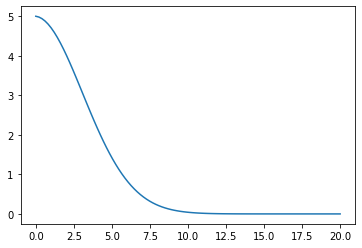

In [50]:
model = Composite()
model.time = np.linspace(0,20,100)
sys1 = Block()

sys1.k = 10
sys1.y = Variable(model.time)

sys1.y[0] = 5.0

def eq1(block):
    dydt = (block.y()[1:] - block.y()[:-1])/np.diff(block.time)
    return block.k*dydt+block.time[1:]*block.y()[1:]
sys1.eq1 = Constraint(eq1 )


model.sys1 = sys1

sim = SimulationProblem(model)
result = sim.run()

model.change_inputs(result.x)
plt.plot(model.time, model.sys1.y())

## Draining tank (same example from part 4 of this series)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in sqrt


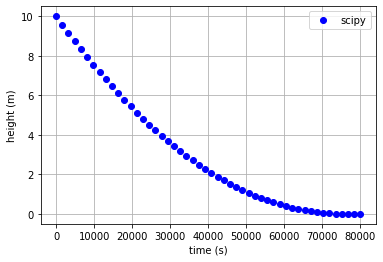

In [51]:
# some constants
RHO = 1000 # kg/m3 density of water
c = 0.62
g = 9.81
A = 16
A_orifice = 5e-4
m0 = 10*A*RHO

model = Composite()
model.time = np.linspace(0, 8e4, 50)

# tank model
tank1 = Block()
tank1.inport_inflow = InPort()
tank1.inport_outflow = InPort()
tank1.mass = Variable(model.time)
tank1.height = Variable(model.time)
tank1.outport_height = OutPort(tank1.height)
tank1.area = A

tank1.mass[0] = m0 # initial condition

def mass_balance(block):
    dmdt = np.diff(block.mass())/np.diff(block.time)
    inflow = block.inport_inflow()
    outflow = block.inport_outflow()
    if inflow is None:
        inflow = np.zeros_like(block.time)
    if outflow is None:
        outflow = np.zeros_like(block.time)
    resid = dmdt - (inflow[1:] - outflow[1:])
    return resid

tank1.mass_balance = Constraint(mass_balance)

def volume_height(block):
    resid = block.mass() - block.area*RHO*block.height()
    return resid

tank1.volume_height = Constraint(volume_height)

# orifice model
orifice = Block()
orifice.mass_flow_rate = Variable(model.time)
orifice.outport_flow = OutPort(orifice.mass_flow_rate)
orifice.inport_head = InPort()
orifice.area = A_orifice

def outflow(block):
    h = block.inport_head()
    resid = block.mass_flow_rate() - RHO*block.area*c*np.sqrt(2*g*h)

    return resid

orifice.mech_energy = Constraint(outflow)

model.tank1 = tank1
model.orifice = orifice
model.connect(tank1.inport_outflow, orifice.outport_flow)
model.connect(orifice.inport_head, tank1.outport_height)

sim = SimulationProblem(model)
result = sim.run()

model.change_inputs(result.x)
plt.plot(model.time, model.tank1.height(), 'bo', label='scipy');
plt.xlabel('time (s)')
plt.ylabel('height (m)')
plt.legend()
plt.grid();

Compare the simulated results with the analytical (exact) one to confirm that all is working as expected.

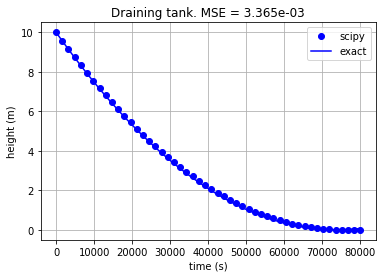

In [55]:
def case1_exact(t):
    A_orifice = 5e-4
    A = 16.0
    h0 = 10.0
    t0 = 0.0
    c = 0.62
    g = 9.81

    h = (np.sqrt(h0) - A_orifice*c*np.sqrt(2*g)*(t-t0)/(2*A))**2

    return h

h_exact = case1_exact(model.time)

# Mean squared errors
MSE = np.mean((model.tank1.height() - h_exact)**2)

plt.plot(model.time, model.tank1.height(), 'bo', label='scipy');
plt.plot( model.time, case1_exact(model.time),'b', label='exact')
plt.xlabel('time (s)')
plt.ylabel('height (m)')
plt.legend()
plt.title(f'Draining tank. MSE = {MSE:.3e}')
plt.grid();

# Conclusion

In this post we have improved the interface of the model by creating classes and using them to hide the internal methods used to perform the simulation. In the next post I want to use inheritance to make the code even more modular and to make it easier to create multiple units with similar physical behavior without repeating the same code. I see you in the next post.